In [192]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [193]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [194]:
df = pd.read_csv('../data/ALLDATA_v2.csv')
print(df.head())

   Unnamed: 0        Date  Day  Month  Year  DayOfWeek  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR      Referee    HS    AS   HST  AST   HC   AC    HF    AF   HY   AY   HR   AR  H14  A14 Attendance  Strictness  Season  Round  Hpts  Apts  HTS  ATS  HGSR  AGSR  Home_DS  Away_DS  Home_Form_Points  Away_Form_Points  Home_Goal_Diff_Form  Away_Goal_Diff_Form  Home_Win_Streak  Away_Win_Streak  Home_H2H_Win_Rate  Away_H2H_Win_Rate  HTV($m)  ATV($m)  HTPos_avg  ATPos_avg  HSPE (%)  HPE (%)  ASPE (%)  APE (%)
0           0  19/08/2000   19      8  2000          7  Charlton       Man City   4.0   0.0   H   2.0   0.0   H     R Harris  17.0   8.0  14.0  4.0  6.0  6.0  13.0  12.0  1.0  2.0  0.0  0.0    0    0     20,043   15.272727    2000      1     0     0  0.0  0.0   0.0   0.0      0.0      0.0               0.0               0.0                  0.0                  0.0                0                0                0.0                0.0      NaN      NaN        NaN        NaN   

In [195]:
from sklearn.impute import KNNImputer

# Select features for KNN
features = ['HS', 'AS', 'HST', 'AST', 'Hpts', 'Apts', 'Home_Form_Points', 'Away_Form_Points']
target_columns = ["HTPos_avg", "ATPos_avg"]

# Create a mask to identify rows with missing values
missing_mask = df[target_columns].isnull()

# Add missingness indicators to the DataFrame
for col in target_columns:
    df[f"{col}_missing"] = missing_mask[col].astype(int)

# Create a copy of the data for imputation
imputation_data = df[features + target_columns].copy()

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(imputation_data)

# Convert imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=features + target_columns)

# Replace only the missing values in the original DataFrame
for col in target_columns:
    df.loc[missing_mask[col], col] = imputed_df.loc[missing_mask[col], col]


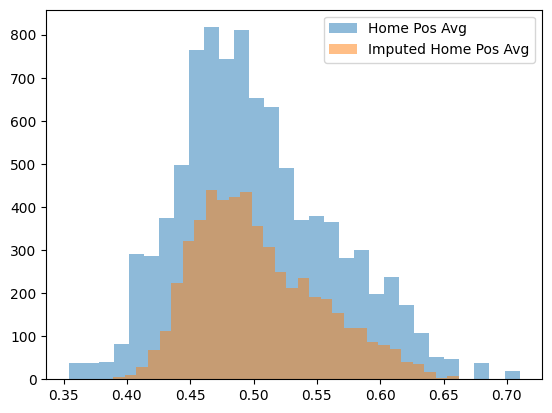

In [196]:
import matplotlib.pyplot as plt

# Visualize imputed vs. non-imputed values
plt.hist(df['HTPos_avg'], bins=30, alpha=0.5, label='Home Pos Avg')
plt.hist(df.loc[missing_mask['HTPos_avg'], 'HTPos_avg'], bins=30, alpha=0.5, label='Imputed Home Pos Avg')
plt.legend()
plt.show()

In [197]:
df = df.drop(df.columns[0], axis=1)
df = df.drop(columns=['Date', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'Attendance', "HTV($m)",	"ATV($m)", "HTPos_avg", "ATPos_avg", "HSPE (%)", "HPE (%)", "ASPE (%)", "APE (%)"],axis=1)
print(df.head())

   Day  Month  Year  DayOfWeek  HomeTeam       AwayTeam FTR      Referee  H14  A14  Strictness  Season  Round  Hpts  Apts  HTS  ATS  HGSR  AGSR  Home_DS  Away_DS  Home_Form_Points  Away_Form_Points  Home_Goal_Diff_Form  Away_Goal_Diff_Form  Home_Win_Streak  Away_Win_Streak  Home_H2H_Win_Rate  Away_H2H_Win_Rate  HTPos_avg_missing  ATPos_avg_missing
0   19      8  2000          7  Charlton       Man City   H     R Harris    0    0   15.272727    2000      1     0     0  0.0  0.0   0.0   0.0      0.0      0.0               0.0               0.0                  0.0                  0.0                0                0                0.0                0.0                  1                  1
1   19      8  2000          7   Chelsea       West Ham   H     G Barber    0    0   13.641026    2000      1     0     0  0.0  0.0   0.0   0.0      0.0      0.0               0.0               0.0                  0.0                  0.0                0                0                0.0        

In [198]:
one_hot_encoded_hometeam = pd.get_dummies(df['HomeTeam'], prefix='HomeTeam')
one_hot_encoded_awayteam = pd.get_dummies(df['AwayTeam'], prefix='AwayTeam')
one_hot_encoded_referee = pd.get_dummies(df['Referee'], prefix='Referee')
one_hot_encoded_ftr = pd.get_dummies(df['FTR'], prefix='FTR')
df = pd.concat([df, one_hot_encoded_hometeam, one_hot_encoded_awayteam, one_hot_encoded_referee, one_hot_encoded_ftr], axis=1)
df = df.drop(columns=['HomeTeam', 'AwayTeam', 'Referee', 'FTR'], axis=1)
print(df.head())

   Day  Month  Year  DayOfWeek  H14  A14  Strictness  Season  Round  Hpts  Apts  HTS  ATS  HGSR  AGSR  Home_DS  Away_DS  Home_Form_Points  Away_Form_Points  Home_Goal_Diff_Form  Away_Goal_Diff_Form  Home_Win_Streak  Away_Win_Streak  Home_H2H_Win_Rate  Away_H2H_Win_Rate  HTPos_avg_missing  ATPos_avg_missing  HomeTeam_Arsenal  HomeTeam_Aston Villa  HomeTeam_Birmingham  HomeTeam_Blackburn  HomeTeam_Blackpool  HomeTeam_Bolton  HomeTeam_Bournemouth  HomeTeam_Bradford  HomeTeam_Brentford  HomeTeam_Brighton  HomeTeam_Burnley  HomeTeam_Cardiff  HomeTeam_Charlton  HomeTeam_Chelsea  HomeTeam_Coventry  HomeTeam_Crystal Palace  HomeTeam_Derby  HomeTeam_Everton  HomeTeam_Fulham  HomeTeam_Huddersfield  HomeTeam_Hull  HomeTeam_Ipswich  HomeTeam_Leeds  HomeTeam_Leicester  HomeTeam_Liverpool  HomeTeam_Luton  HomeTeam_Man City  HomeTeam_Man United  HomeTeam_Middlesbrough  HomeTeam_Newcastle  HomeTeam_Norwich  HomeTeam_Nott'm Forest  HomeTeam_Portsmouth  HomeTeam_QPR  HomeTeam_Reading  \
0   19      8  2

In [201]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import BatchNormalization
import keras_tuner

X = df.drop(columns=['FTR_A', 'FTR_D', 'FTR_H'])
y = df[['FTR_A', 'FTR_D', 'FTR_H']]


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(y.shape[1]),
    y=np.argmax(y.values, axis=1)
)
class_weights = dict(enumerate(class_weights))

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred = model.predict(X_test)
y_pred_original = np.argmax(y_pred, axis=1)
y_test_original = np.argmax(y_test.values, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test_original, y_pred_original))

print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))


Epoch 1/100


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3881 - loss: 1.1321 - val_accuracy: 0.4534 - val_loss: 1.0483 - learning_rate: 0.0010
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4606 - loss: 1.0364 - val_accuracy: 0.5007 - val_loss: 1.0135 - learning_rate: 0.0010
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4787 - loss: 1.0354 - val_accuracy: 0.4801 - val_loss: 1.0269 - learning_rate: 0.0010
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4799 - loss: 1.0288 - val_accuracy: 0.5068 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5083 - loss: 1.0076 - val_accuracy: 0.4870 - val_loss: 1.0247 - learning_rate: 0.0010
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5057 - loss: 1.0102 - val_accuracy: 0.5048 - val_loss: 1.0090 - learning_rate: 0.0010
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5347 - loss: 0.9744 - val_a